In [15]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import convolve1d
import scipy
import matplotlib.patches as patches


from cca.data_util import moving_center, load_sabes_data, calc_autocorr_fns
from cca.cov_util import calc_cross_cov_mats_from_data, calc_pi_from_cross_cov_mats
from cca import ComplexityComponentsAnalysis

In [2]:
dirname = "/home/davidclark/Projects/ComplexityComponentsAnalysis/data/sabes/"
#dirname = "/Users/davidclark/Projects/ComplexityComponentsAnalysis/data/sabes/"
session = "indy_20160627_01.mat"
filename = dirname + session
results = load_sabes_data(filename, bin_width_s=.100)
spikes = results["M1"]
spikes = spikes[:, spikes.sum(axis=0) > 5000]
sqrt_spikes = np.sqrt(spikes)
sqrt_spikes_ctd = moving_center(sqrt_spikes, n=1200)
cursor = results["cursor"]

In [3]:
#TODO: compare PI vs dim for reg, reg+deflat., FFT+deflat

opt = ComplexityComponentsAnalysis(init="random")
cross_cov_mats = calc_cross_cov_mats_from_data(sqrt_spikes_ctd, T=40)

opt.cross_covs = cross_cov_mats[:2]
opt.fit_projection(d=1, n_init=10)
V1 = opt.coef_
x1 = np.dot(sqrt_spikes_ctd, V1)

opt.cross_covs = cross_cov_mats[:40]
opt.fit_projection(d=1, n_init=10)
V2 = opt.coef_
x2 = np.dot(sqrt_spikes_ctd, V2)

In [8]:
autocorr_fn_1 = calc_autocorr_fns(x1, T=20).flatten()
autocorr_fn_2 = calc_autocorr_fns(x2, T=20).flatten()

autocorr_fn_1 /= autocorr_fn_1[0]
autocorr_fn_2 /= autocorr_fn_2[0]

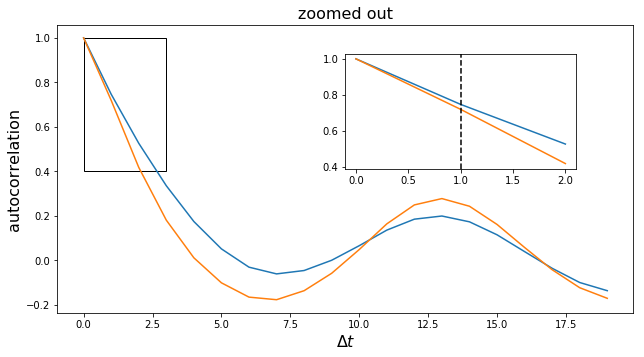

In [24]:
wpad_left = 0.1
wpad_right = 0.1
hpad_top = 0.1
hpad_bottom = 0.1
fig_width, fig_height = 10, 5

fig = plt.figure(figsize=(fig_width, fig_height))
ax_width = 1. - wpad_left - wpad_right
ax_height = 1. - hpad_top - hpad_bottom
ax = fig.add_axes((wpad_left, hpad_bottom, ax_width, ax_height))

ax.plot(autocorr_fn_1, label="$T_{PI} = 1$")
ax.plot(autocorr_fn_2, label="$T_{PI} = 20$")
ax.set_title("zoomed out", fontsize=16)
ax.set_xlabel("$\Delta t$", fontsize=16)
ax.set_ylabel("autocorrelation", fontsize=16)

inset_wpad_left_rel = 0.5
inset_wpad_right_rel = 0.1
inset_hpad_bottom_rel = 0.5
inset_hpad_top_rel = 0.1
inset_width_rel = 1. - inset_wpad_left_rel - inset_wpad_right_rel
inset_height_rel = 1. - inset_hpad_top_rel - inset_hpad_bottom_rel

inset_wpad_left_abs = wpad_left + ax_width*inset_wpad_left_rel
inset_hpad_bottom_abs = hpad_bottom + ax_height*inset_hpad_bottom_rel
inset_width_abs = ax_width*inset_width_rel
inset_height_abs = ax_height*inset_height_rel

ax_inset = fig.add_axes((inset_wpad_left_abs, inset_hpad_bottom_abs, inset_width_abs, inset_height_abs))

rect = patches.Rectangle((0.0, 0.4), 3, 0.6, linewidth=1, edgecolor="black", facecolor="none")
ax.add_patch(rect)

#ax1.legend()


ax_inset.plot(autocorr_fn_1[:3])
ax_inset.plot(autocorr_fn_2[:3])
#ax_inset.set_ylabel("autocorrelation", fontsize=16)
#ax_inset.set_xlabel("$\Delta t$", fontsize=16)
#ax2.set_title("zoomed in", fontsize=16)
ax_inset.axvline(1, color="black", linestyle="--")

#plt.savefig("figures/autocorr_disp.pdf", bbox_inches="tight")


In [203]:
def dca_deflation(cross_cov_mats, n_proj, n_init=1):
    N = cross_cov_mats.shape[1] #data dimensionality
    P = np.eye(N) #orthogonal projection matrix onto residual subspace, which we will form...
    V = None  #basis of DCA projections, which we will grow... 
    opt = ComplexityComponentsAnalysis(init="random")
    for i in range(n_proj):
        cross_cov_mats_proj = np.array([P.dot(C).dot(P.T) for C in cross_cov_mats])
        if i > 0:
            cross_cov_mats_proj[0] += 1e2 * np.dot(V, V.T)
        opt.cross_covs = cross_cov_mats_proj
        opt.fit_projection(d=1, n_init=n_init)
        u = opt.coef_
        if i == 0:
            V = u
        else:
            u_proj = np.dot(np.eye(N) - np.dot(V, V.T), u)
            u_proj /= np.sqrt(np.sum(u_proj**2))
            print(np.sum((u - u_proj)**2))
            V = np.concatenate((V, u_proj), axis=1)
            print(np.dot(V.T, V))
        P = np.eye(N) - np.dot(V, V.T)
    return V

def dca_ordered(cross_cov_mats, n_proj, n_init=1):
    opt = ComplexityComponentsAnalysis(init="random")
    opt.cross_covs = cross_cov_mats
    V_all = []
    for i in range(n_proj):
        opt.fit_projection(d=i+1, n_init=n_init)
        V = opt.coef_
        V_all.append(V)
    return V_all

def calc_pi_vs_dim(cross_cov_mats, V=None, V_all=None):
    if V_all is None:
        V_all = [V[:, :i+1] for i in range(V.shape[1])]
    pi_vals = np.zeros(len(V_all))
    for i in range(len(V_all)):
        pi_vals[i] = calc_pi_from_cross_cov_mats(cross_cov_mats, proj=V_all[i])
    return pi_vals
    
cross_cov_mats = calc_cross_cov_mats_from_data(sqrt_spikes_ctd, T=2)

In [212]:
n_proj = 50
n_init = 5

V_deflate = dca_deflation(cross_cov_mats, n_proj=n_proj, n_init=n_init)
V_all = dca_ordered(cross_cov_mats, n_proj=n_proj, n_init=n_init)

angles = np.rad2deg(scipy.linalg.subspace_angles(V_deflate, V_all[-1]))
print(angles)

6.526464720326836e-14
[[1.00000000e+00 1.39638235e-17]
 [1.39638235e-17 1.00000000e+00]]
1.361732664810029e-10
[[ 1.00000000e+00  1.39638235e-17 -1.28669868e-17]
 [ 1.39638235e-17  1.00000000e+00 -1.01684922e-18]
 [-1.28669868e-17 -1.01684922e-18  1.00000000e+00]]
3.52712447756237e-08
[[ 1.00000000e+00  3.91918528e-17 -1.28669868e-17  3.04101164e-17]
 [ 3.91918528e-17  1.00000000e+00 -1.01684922e-18 -2.88927454e-17]
 [-1.28669868e-17 -1.01684922e-18  1.00000000e+00 -1.28502815e-17]
 [ 3.04101164e-17 -2.88927454e-17 -1.28502815e-17  1.00000000e+00]]
1.136166583848178e-09
[[ 1.00000000e+00  3.91918528e-17 -1.28669868e-17  3.04101164e-17
  -6.19174995e-17]
 [ 3.91918528e-17  1.00000000e+00 -1.01684922e-18 -2.88927454e-17
   1.37688862e-17]
 [-1.28669868e-17 -1.01684922e-18  1.00000000e+00 -1.28502815e-17
  -1.64763944e-17]
 [ 3.04101164e-17 -2.88927454e-17 -1.28502815e-17  1.00000000e+00
  -2.01129805e-17]
 [-6.19174995e-17  1.37688862e-17 -1.64763944e-17 -2.01129805e-17
   1.00000000e+00

2.64609407033832e-09
[[ 1.00000000e+00  1.39638235e-17 -8.55728319e-18  1.21955199e-17
  -1.22610400e-17 -1.55759794e-18  1.68887478e-17 -5.59943085e-18
   2.78844055e-17  2.13054010e-17 -1.54854341e-18 -1.19398806e-17
   2.40483477e-17]
 [ 1.39638235e-17  1.00000000e+00 -6.07801058e-17 -6.43461564e-17
  -3.80874155e-18  2.96550756e-17 -1.57999011e-17 -1.76441816e-18
   2.10944950e-18  8.93030049e-18  1.14425747e-17 -3.19681188e-17
   6.35852214e-18]
 [-8.55728319e-18 -6.07801058e-17  1.00000000e+00 -2.75954310e-17
  -5.31224278e-17 -3.80679480e-17  2.17658557e-18 -2.23747922e-17
   4.73691164e-18 -1.09957033e-19  1.50109547e-17 -1.20266397e-17
   1.93211440e-17]
 [ 1.21955199e-17 -6.43461564e-17 -2.75954310e-17  1.00000000e+00
  -3.19942665e-18  2.35501489e-17 -1.89490561e-17  2.54183680e-17
  -1.04464053e-17  2.71261810e-17  1.19353704e-17 -4.49992870e-17
  -4.12702056e-17]
 [-1.22610400e-17 -3.80874155e-18 -5.31224278e-17 -3.19942665e-18
   1.00000000e+00 -5.00305332e-18 -2.97880321

0.152750453236133
[[ 1.00000000e+00  1.39638235e-17 -8.55728319e-18  1.21955199e-17
  -1.22610400e-17 -1.55759794e-18  1.68887478e-17 -5.59943085e-18
   2.78844055e-17  2.13054010e-17 -1.54854341e-18 -1.19398806e-17
   2.21509939e-17 -8.42159199e-18 -5.62244983e-17  2.89191903e-17
  -7.75106306e-18 -4.82303494e-17  1.93180168e-17 -2.12442827e-17
   4.10231310e-17  4.54502424e-18  1.40945222e-17 -4.87956711e-18]
 [ 1.39638235e-17  1.00000000e+00 -6.07801058e-17 -6.43461564e-17
  -3.80874155e-18  2.96550756e-17 -1.57999011e-17 -1.76441816e-18
   2.10944950e-18  8.93030049e-18  1.14425747e-17 -3.19681188e-17
   1.28637352e-17 -2.27107165e-18 -5.02548315e-17  1.12799699e-17
  -4.40291032e-19  1.84650709e-17  1.14172691e-17 -2.88718687e-17
   1.85481003e-17  1.02637544e-16 -1.32768441e-17 -4.12013286e-17]
 [-8.55728319e-18 -6.07801058e-17  1.00000000e+00 -2.75954310e-17
  -5.31224278e-17 -3.80679480e-17  2.17658557e-18 -2.23747922e-17
   4.73691164e-18 -1.09957033e-19  1.50109547e-17 -1.202

0.17554157867068823
[[ 1.00000000e+00  1.39638235e-17 -8.55728319e-18 ... -3.31101258e-17
   7.94854793e-18 -5.92477091e-17]
 [ 1.39638235e-17  1.00000000e+00 -6.07801058e-17 ... -3.32595455e-17
  -3.64731138e-17  4.34458134e-17]
 [-8.55728319e-18 -6.07801058e-17  1.00000000e+00 ...  5.64112212e-18
   9.40441674e-18  3.34142487e-17]
 ...
 [-3.31101258e-17 -3.32595455e-17  5.64112212e-18 ...  1.00000000e+00
  -6.68532913e-17 -6.69540166e-18]
 [ 7.94854793e-18 -3.64731138e-17  9.40441674e-18 ... -6.68532913e-17
   1.00000000e+00  6.90638080e-18]
 [-5.92477091e-17  4.34458134e-17  3.34142487e-17 ... -6.69540166e-18
   6.90638080e-18  1.00000000e+00]]
0.30899559095590834
[[ 1.00000000e+00  1.39638235e-17 -8.55728319e-18 ...  7.94854793e-18
  -5.92477091e-17 -8.23668036e-17]
 [ 1.39638235e-17  1.00000000e+00 -6.07801058e-17 ... -3.64731138e-17
   4.34458134e-17 -1.55336491e-17]
 [-8.55728319e-18 -6.07801058e-17  1.00000000e+00 ...  9.40441674e-18
   3.34142487e-17  9.45536085e-18]
 ...
 [ 7

KeyboardInterrupt: 

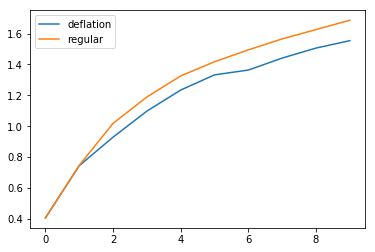

In [211]:
pi_deflate = calc_pi_vs_dim(cross_cov_mats, V=V_deflate)
pi_regular = calc_pi_vs_dim(cross_cov_mats, V_all=V_all)

plt.plot(pi_deflate, label="deflation")
plt.plot(pi_regular, label="regular")
plt.legend()

In [169]:
def calc_pi_vs_dim(cross_cov_mats, V):
    pi_vals = np.zeros(V.shape[1])
    for i in range(V.shape[1]):
        calc_pi_from_cross_cov_mats(cross_cov_mats, proj=V[:i+1])
    return pi_vals
    

In [22]:
import matplotlib
matplotlib.__version__

'2.2.2'